In [3]:
import os
import glob
import pickle
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 6)

DATASET_ROOT = "/home/ntdung/Medical/CV/dataset"
TRAIN_DIR = os.path.join(DATASET_ROOT, "train")
PUBLIC_TEST_DIR = os.path.join(DATASET_ROOT, "public_test")
PRIVATE_TEST_DIR = os.path.join(DATASET_ROOT, "private_test")
LABEL_MAP_PATH = os.path.join(DATASET_ROOT, "label_mapping.pkl")

print(f"Root path: {DATASET_ROOT}")
if os.path.exists(DATASET_ROOT):
    print("Data directory found.")
else:
    print("Directory not found.")

Root path: /home/ntdung/Medical/CV/dataset
Data directory found.


In [5]:
# Get file lists
train_files = glob.glob(os.path.join(TRAIN_DIR, "*", "*.mp4"))
public_test_files = glob.glob(os.path.join(PUBLIC_TEST_DIR, "*.mp4"))
private_test_files = glob.glob(os.path.join(PRIVATE_TEST_DIR, "*.mp4"))

print(f"Videos in Train set: {len(train_files)} (Expected: 3875)")
print(f"Videos in Public Test set: {len(public_test_files)} (Expected: 1630)")
print(f"Videos in Private Test set: {len(private_test_files)} (Expected: 2859)")

print("\nExample 3 paths in Train set:")
for p in train_files[:3]: print(p)

Videos in Train set: 3875 (Expected: 3875)
Videos in Public Test set: 1630 (Expected: 1630)
Videos in Private Test set: 2859 (Expected: 2859)

Example 3 paths in Train set:
/home/ntdung/Medical/CV/dataset/train/Cá/465962.mp4
/home/ntdung/Medical/CV/dataset/train/Cá/176819.mp4
/home/ntdung/Medical/CV/dataset/train/Cá/109767_1.mp4


In [6]:
if os.path.exists(LABEL_MAP_PATH):
    with open(LABEL_MAP_PATH, 'rb') as f:
        label_map = pickle.load(f)
    
    print(f"Total classes: {len(label_map)}")
    print("-" * 30)
    print("First 5 classes in mapping:")
    
    for i, (k, v) in enumerate(label_map.items()):
        if i < 5:
            print(f"Label: '{k}' -> ID: {v}")
        else:
            break
            
    # Reverse map for ID -> Label lookup
    id_to_label = {v: k for k, v in label_map.items()}
else:
    print("label_mapping.pkl not found")

Total classes: 100
------------------------------
First 5 classes in mapping:
Label: 'An ủi' -> ID: 0
Label: 'Áp dụng' -> ID: 1
Label: 'Ăn' -> ID: 2
Label: 'Ăn mừng' -> ID: 3
Label: 'Ban ngày' -> ID: 4


Class with most videos: Trường học (74 videos)
Class with fewest videos: Cách ly (6 videos)
Average videos per class: 38.75


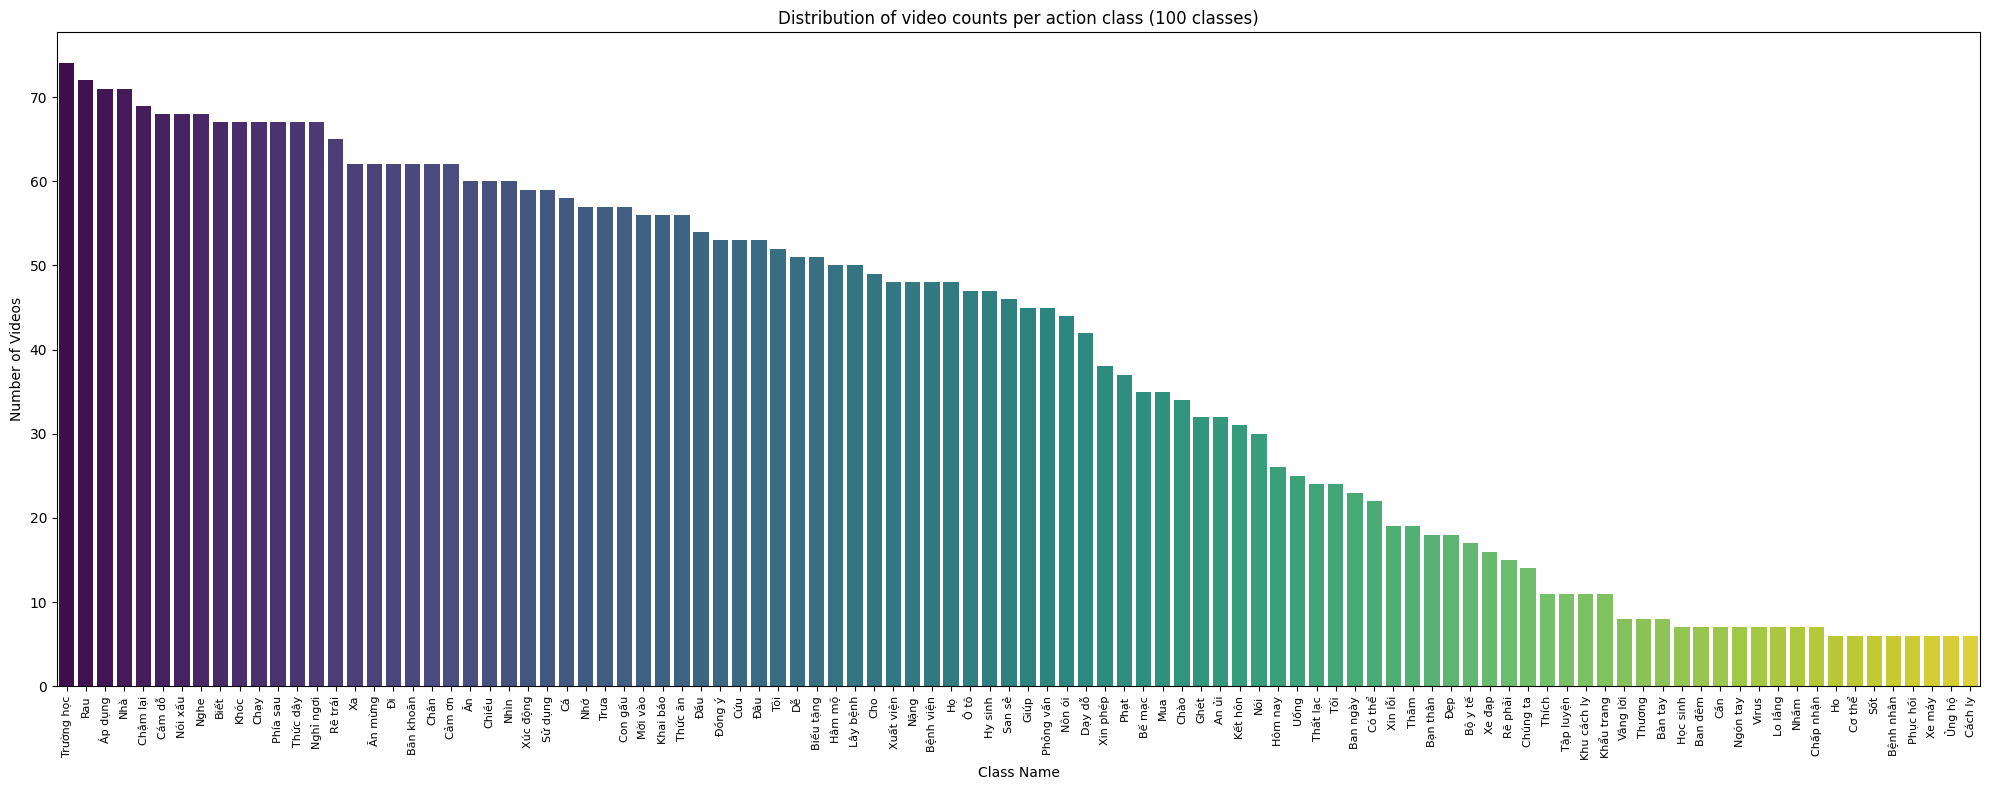

In [11]:
# Extract class names from train file paths
train_labels = [os.path.basename(os.path.dirname(f)) for f in train_files]

df_train = pd.DataFrame(train_labels, columns=['label'])
label_counts = df_train['label'].value_counts()

print(f"Class with most videos: {label_counts.index[0]} ({label_counts.iloc[0]} videos)")
print(f"Class with fewest videos: {label_counts.index[-1]} ({label_counts.iloc[-1]} videos)")
print(f"Average videos per class: {label_counts.mean():.2f}")

plt.figure(figsize=(20, 8))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis", hue=label_counts.index, legend=False)
plt.xticks(rotation=90, fontsize=8)
plt.title("Distribution of video counts per action class (100 classes)")
plt.xlabel("Class Name")
plt.ylabel("Number of Videos")
plt.tight_layout()
plt.show()

In [12]:
def get_video_info(video_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return None
    
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = frame_count / fps if fps > 0 else 0
    
    cap.release()
    return {'width': width, 'height': height, 'fps': fps, 'frames': frame_count, 'duration': duration}

import random
sample_videos = random.sample(train_files, 5)

print(f"{'File Name':<20} | {'Res (WxH)':<12} | {'FPS':<5} | {'Frames':<6} | {'Duration(s)':<10}")
print("-" * 70)

for vid_path in sample_videos:
    info = get_video_info(vid_path)
    if info:
        vid_name = os.path.basename(vid_path)
        vid_name_short = (vid_name[:17] + '..') if len(vid_name) > 17 else vid_name
        print(f"{vid_name_short:<20} | {info['width']}x{info['height']:<6} | {info['fps']:<5.1f} | {info['frames']:<6} | {info['duration']:<10.2f}")

File Name            | Res (WxH)    | FPS   | Frames | Duration(s)
----------------------------------------------------------------------
547494.mp4           | 224x224    | 14.1  | 30     | 2.13      
927564_2.mp4         | 224x224    | 9.6   | 30     | 3.14      
188425.mp4           | 224x224    | 17.9  | 30     | 1.68      
405420.mp4           | 224x224    | 14.1  | 30     | 2.13      
530764_2.mp4         | 224x224    | 9.9   | 30     | 3.02      


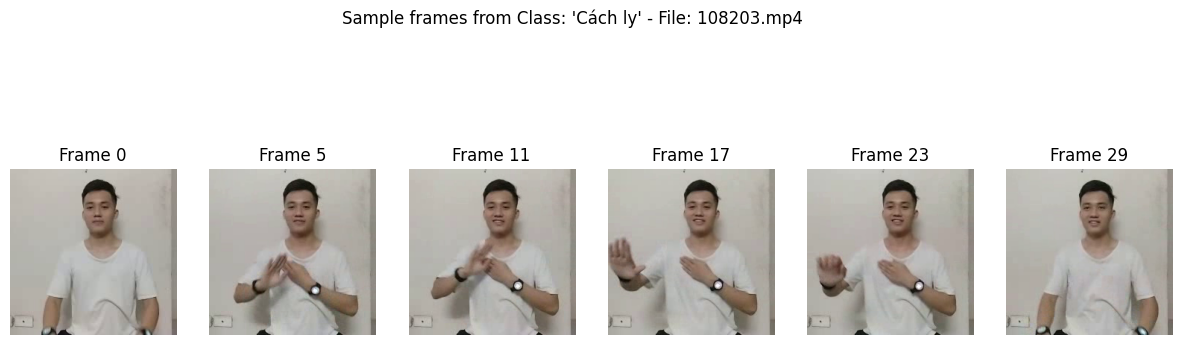

In [14]:
def visualize_video_frames(video_path, num_frames=5):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Get evenly spaced frame indices
    frame_indices = np.linspace(0, total_frames-1, num_frames, dtype=int)
    
    plt.figure(figsize=(15, 5))
    folder_name = os.path.basename(os.path.dirname(video_path))
    file_name = os.path.basename(video_path)
    plt.suptitle(f"Sample frames from Class: '{folder_name}' - File: {file_name}")

    for i, idx in enumerate(frame_indices):
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if ret:
            # Convert BGR (OpenCV) to RGB (Matplotlib)
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            
            plt.subplot(1, num_frames, i + 1)
            plt.imshow(frame_rgb)
            plt.axis('off')
            plt.title(f"Frame {idx}")
    
    cap.release()
    plt.show()

random_video = random.choice(train_files)
visualize_video_frames(random_video, num_frames=6)